In [2]:
# Import necessary libraries
import cv2
import numpy as np
import os
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [3]:
def normalize_keypoints(sequence):
    # Reshape sequence to (frames, keypoints, coordinates)
    sequence = sequence.reshape(sequence.shape[0], -1, 3)
    normalized_sequence = []
    for frame in sequence:
        # Left Hand
        left_hand = frame[:21, :]
        if np.any(left_hand):
            left_hand_center = left_hand[0, :]  # Wrist
            left_hand = left_hand - left_hand_center  # Center the hand
            hand_size = np.linalg.norm(left_hand[9, :])  # Middle finger MCP
            if hand_size > 0:
                left_hand = left_hand / hand_size  # Scale the hand
            else:
                left_hand = np.zeros((21, 3))
        else:
            left_hand = np.zeros((21, 3))

        # Right Hand
        right_hand = frame[21:, :]
        if np.any(right_hand):
            right_hand_center = right_hand[0, :]  # Wrist
            right_hand = right_hand - right_hand_center  # Center the hand
            hand_size = np.linalg.norm(right_hand[9, :])  # Middle finger MCP
            if hand_size > 0:
                right_hand = right_hand / hand_size  # Scale the hand
            else:
                right_hand = np.zeros((21, 3))
        else:
            right_hand = np.zeros((21, 3))

        # Concatenate normalized keypoints
        frame_normalized = np.concatenate([left_hand, right_hand], axis=0)
        normalized_sequence.append(frame_normalized.flatten())
    return np.array(normalized_sequence)


In [ ]:
# !unzip '/content/drive/MyDrive/Colab/Autumn 2025/Untitled folder/AUSLAN_Data.zip' -d '/content/'

In [4]:
# Define paths and actions
DATA_PATH = os.path.join('/Users/robayedashraf/Downloads/LSTM_AUSLAN_Real_Time_FigerSpelling_Recognization-main/Real_Time_Gensture_Recognization/Dataset')

# Actions to detect
actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
                    'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

# Number of sequences and sequence length
no_sequences = 60
sequence_length = 30

# Label mapping
label_map = {label: num for num, label in enumerate(actions)}

In [5]:
sequences, labels = [], []
for action in actions:
    for sequence_num in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_num), f"{frame_num}.npy"))
            # Extract only hand keypoints

            res = res[-(21*3*2):]  # Assuming hand keypoints are at the end
            window.append(res)
        window = np.array(window)

        # Normalize keypoints
        window_normalized = normalize_keypoints(window)
        sequences.append(window_normalized)
        labels.append(label_map[action])


In [6]:
sequences = np.array(sequences)
labels = np.array(labels)

In [7]:
from sklearn.model_selection import train_test_split

# Optionally normalize data if needed, for example:
# sequences = sequences.astype('float32') / np.max(sequences)

X_train, X_test, y_train, y_test = train_test_split(
    sequences, labels, test_size=0.3, random_state=42, stratify=labels
)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalAveragePooling1D

num_classes = 26
feature_dim = sequences.shape[2]  # Extracted from your npy files
sequence_length = sequences.shape[1]  # This should be 30

model = Sequential([
    # First convolutional block with 64 filters and kernel size of 3
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(sequence_length, feature_dim)),
    Dropout(0.4),
    
    # Second convolutional block with 32 filters
    Conv1D(32, kernel_size=3, activation='relu'),
    Dropout(0.4),
    
    # Global pooling to reduce the feature maps to a single vector
    GlobalAveragePooling1D(),
    
    # Dense layers similar to your original model
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │        24,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,346 (126.35 KB)

 Trainable params: 32,346 (126.35 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1202 - loss: 3.0950 - val_accuracy: 0.4316 - val_loss: 2.2556
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4629 - loss: 2.0525 - val_accuracy: 0.6752 - val_loss: 1.2461
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 1.1897 - val_accuracy: 0.7778 - val_loss: 0.6916
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7624 - loss: 0.7711 - val_accuracy: 0.8355 - val_loss: 0.4824
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8027 - loss: 0.5738 - val_accuracy: 0.8632 - val_loss: 0.4006
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7934 - loss: 0.5230 - val_accuracy: 0.8782 - val_loss: 0.3221
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.4106 - val_accuracy: 0.9081 - val_loss: 0.2925
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8874 - loss: 0.3438 - val_accuracy: 0.9081 - val_loss:

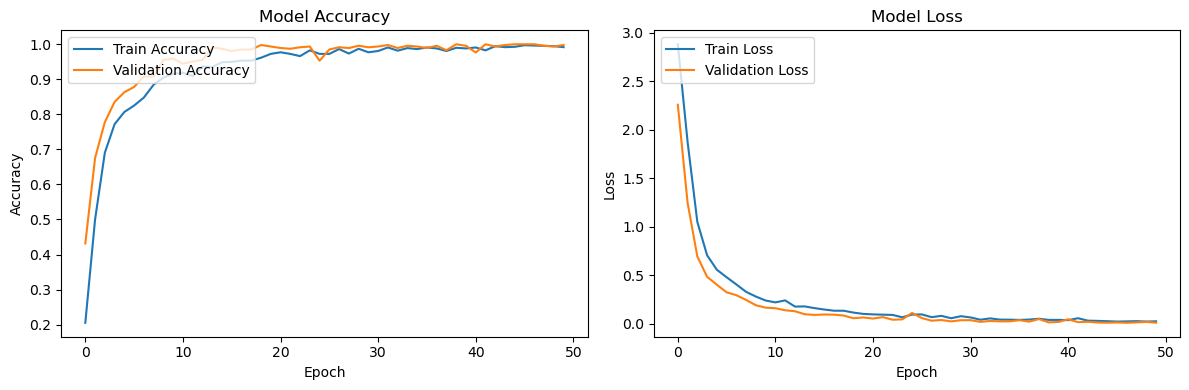

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# After training your model, call the function:
plot_training_history(history)

In [11]:
model.save('model.h5')